# Sentiment analysis of IMDB movie reviews with various machine learning algorithms

## I Introduction
TBC

## II Implementation
In this section, we will preprocess that dataset, build and test the classifier, and obtain results.

This project is an evolution of the Kaggle notebook created by user Lakshmipathi N. Code adapted closely from her notebook will be indicated with a comment '#Lakshmipathi N 2020'.
Where I have taken inspiration or guidance from other notebooks or code, similar comments with the author's name will be given. A comprehensive bibliography is provided at the end of the project.

My own code or code that has been significantly adapted will be marked with a '#New Code' comment.

In [32]:
# Import necessary libraries
import pandas as pd

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
import os

#Adapted code from Lakshmipathi N 2020 with some changes - see bibliography for full reference.

[nltk_data] Downloading package stopwords to /Users/silvercloud-
[nltk_data]     lene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We'll import the data from the .csv file into two variables using Pandas. We'll use imdb_data to apply the preprocessing steps from Lakshmipathi N's notebook and use this to train a Multinomial Naive Bayes model. We'll replicate Lakshmipathi N's performance and use this as a baseline.

The imdb_data_raw will be used to make adjustments to see if we can improve the baseline performance.

In [2]:
#Import training data
imdb_data=pd.read_csv('IMDB_Dataset.csv')
imdb_data_raw = pd.read_csv('IMDB_Dataset.csv')

#Adapted from Lakshmipathi N 2020

### Exploratory data analysis
We will now explore the data and see what we are working with. This is useful to help us see what type of cleaning we need to do.`

#### Summary of the dataset
Let's use describe() to get an overview of the dataset.

In [9]:
imdb_data.describe()
#Lakshmipathi N 2020

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


We can also print out the shape of our dataset to see the number of rows and columns.

In [16]:
print(imdb_data.shape)
#Lakshmipathi N 2020

(50000, 2)


And we can use the head() function to see the first 10 rows.

In [17]:
imdb_data.head(10)
#Lakshmipathi N 2020

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Note the "</ br>" text - this is probably something we want to remove. We can use a wordcloud to help us see some other potential problems too.

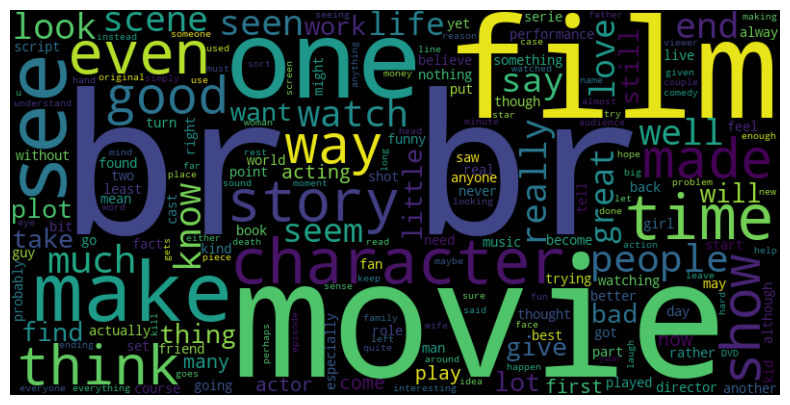

In [22]:
# Concatenate the text from the review column into a single string.
wordcloud_text = ' '.join(df['review'])

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400).generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Adapted from Valkov 2019

Looks good, other than the "br" which we'll have to deal with.

#### Sentiment distribution
We want to ensure that we have a balanced dataset to avoid introducing bias into our model.


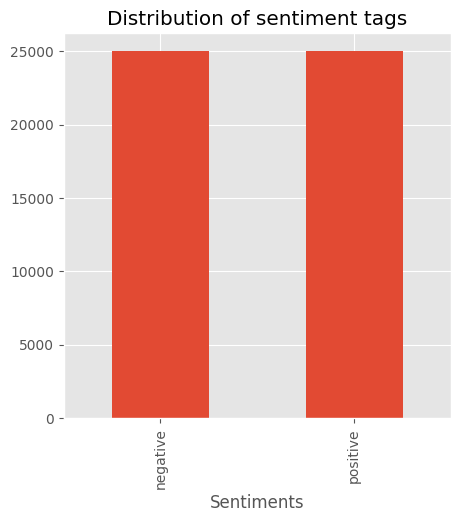

In [39]:
# Draw a bar chart to show the distribution of the data in the sentiment column.
axis = df['sentiment'].value_counts().sort_index()\
    .plot(kind="bar",
          title="Distribution of sentiment tags",
          figsize=(5,5))
axis.set_xlabel('Sentiments')
plt.show()
# New Code

Looks like the dataset is balanced. Great!

### Data preparation
In this section we'll clean up the data. We'll be following Lakshmipathi N's approach to preprocessing for now and then introduce some additional steps later.

According to Valkov (2019) we should be aware that real world text data can be messy. When working with this dataset, they recommend removing HTML tags, punctuation and other special characters, and any excessive spaces.

We'll creat some functions to do this cleaning for us and then apply them to the IMDB data.

#### Removing HTML and other junk text
The strip_html() function uses the BeautifulSoup library to remove HTML tags from the input text. It takes a string text as input, creates a BeautifulSoup object using the provided HTML parser, and then extracts the text content from the HTML using the get_text() method. The function returns the cleaned text without any HTML tags.

The remove_between_square_brackets() function uses regular expressions (re) to remove text enclosed within square brackets (e.g., [some text]) from the input text. It takes a string text as input and uses the re.sub() function to substitute any occurrences of the pattern '\[[^]]*\]' (which matches any text between square brackets) with an empty string. The function returns the modified text with the square brackets and the enclosed text removed.

The remove_junk_text(text) function applies the above two cleaning operations to the input text. It first calls strip_html(text) to remove HTML tags and then applies remove_between_square_brackets(text) to remove text between square brackets. The cleaned text is then returned.

In [3]:
#Function to strip HTML tags
def strip_html(text):
    # Check if the input looks like a file name
    if os.path.isfile(text):
        with open(text, 'r') as file:
            soup = BeautifulSoup(file, "html.parser")
    else:
        soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Function that combines the above to functions to clean up junk text
def remove_junk_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Apply the remove_junk_text function to the IMDB dataset
imdb_data['review'] = imdb_data['review'].apply(remove_junk_text)

#Adapted code from Lakshmipathi N 2020 with some changes

/var/folders/fp/sfmgsyr555b7vfy1lp18nrjw0000gn/T/ipykernel_94782/3089871143.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [31]:
# Check if the "<br>" tags we saw before has been removed.
imdb_data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


#### Removing special characters
In the remove_special_characters() function, we use the text argument to signify the input text to be processed. The function uses a regular expression pattern matches any character that isn't an uppercase or lowercase letter, a digit, or a whitespace. We then convert all of these matched characters to '' (nothing) to remove them.

In [32]:
# Function to remove special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Apply the remove_special_characters function to the dataset review  column
imdb_data['review'] = imdb_data['review'].apply(remove_special_characters)

#Lakshmipathi N 2020

#### Removing excessive spaces
The re.sub() function from the re module is used to substitute one or more consecutive whitespace characters (\s+) with a single space ' ' in the input text. This effectively removes excessive spaces and replaces them with a single space. The strip() method is applied to the cleaned text to remove any leading or trailing whitespace that might have been introduced during the space removal process. The function returns the cleaned text.

In [33]:
# The function to remove white spaces
def remove_excessive_spaces(text):
    cleaned_text = re.sub('\s+', ' ', text)
    return cleaned_text.strip()

# Apply the function to the review column of the IMDB data
imdb_data['review'] = imdb_data['review'].apply(remove_excessive_spaces)

# New Code

#### Text stemming
Here we will be stemming the text using the Porter stemming algorithm and applying it to the 'review' column of the imdb_data dataframe.
By applying stemming, the code reduces words to their base or root form, which can help in text analysis tasks such as text classification, information retrieval, or topic modeling. Stemming aims to normalize words and treat different variations of the same word as the same base word.

In [37]:
#Stemming the text with the Porter stemming algorithm from NLTK
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

# Check the result of the stemming process
imdb_data.head(5)

#Lakshmipathi N 2020

### Removing stopwords
By removing stopwords we try to eliminate common words that often do not contribute significant meaning to the text analysis tasks. This can help improve the accuracy and efficiency of NLP applications such as sentiment analysis.

First, we set the stopwords list to English, and then let's just check the list of words that will be excluded in the next step.

In [9]:
# # Setting English stopwords
# stopword_list = nltk.corpus.stopwords.words('english')

#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#Lakshmipathi N 2020

{'but', 'our', 'between', 'why', 'up', "doesn't", 'when', 'there', 'what', 'have', 'which', 'are', 'only', 'him', 'further', "wasn't", 'just', 'under', 'for', "should've", 'in', 'herself', 'ain', 'then', 'whom', 'because', 'by', 'other', 'been', 'were', "hasn't", 'you', 'was', 'with', 'so', 'or', 'doing', 'her', 'we', 'all', 'is', 'any', 'can', 'those', 'am', 'nor', "couldn't", 'its', 'didn', 'should', 'his', 'did', 'i', 'me', 'again', 'as', "it's", 'this', 'of', 'no', "needn't", 'most', 'on', 'she', 'while', "aren't", 'few', 'own', 'more', 'about', 'against', 'shan', 'into', 'to', 'll', 'how', "won't", 'such', 'had', 'the', "isn't", "you've", 'both', 'very', 'where', 'their', 'themselves', 'ours', "haven't", 'my', 'over', "wouldn't", 'yourself', 'm', 'down', 'off', 'same', 'a', "mightn't", 'wasn', 'has', 'yourselves', 'ourselves', 'aren', 'wouldn', "shan't", 'they', 'hers', 'being', 's', 'haven', 'here', 'doesn', 'be', 'too', 'will', 'mustn', 'do', 'them', 'at', 'y', 'theirs', 'mightn

 The tokenizer.tokenize() method is used to tokenize the input text into individual words or tokens. The tokens are then cleaned by stripping any leading or trailing whitespace using token.strip().

Based on the is_lower_case parameter, the function conditionally removes stopwords. If is_lower_case is True, the filtered_tokens list is created by excluding tokens that are present in the stop set. If is_lower_case is False, the filtered_tokens list is created by excluding tokens (in lowercase) that are present in the stop set. This allows for case-insensitive removal of stopwords.

The filtered_tokens are then joined back into a string using ' '.join(filtered_tokens) to obtain the filtered text.

In [18]:
#Initialise a tokenizer
tokenizer=ToktokTokenizer()

# Function to remove the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

#Lakshmipathi N 2020

# Test an example
review = "This is an example review with stopwords."
filtered_review = remove_stopwords(review)
print(filtered_review)
#New Code

example review stopwords .


### Feature extraction
In this section we'll do some work to represent the text data numerically by extracting relevant features. We'll use the Bag-of-Words model, where each review is represented as a vector of word frequencies or presence/absence indicators. This will pair well with the Naive Bayes model we'll be using later.

Let's use the CountVectorizer from the scikit-learn library to perform feature extraction with a bag-of-words approach.

In [19]:
# Use the CountVectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# Transform reviews
cv_reviews=cv.fit_transform(imdb_data.review)

# Check results
print('Bag of Words - cv_reviews:',cv_reviews.shape)


#Adapted code from Lakshmipathi N 2020 with some changes

Bag of Words - cv_reviews: (50000, 7914506)


We also need to convert the sentiment data into binary form. This is because when optimizing for sentiment analysis, occurrence of a word matters more than the frequency of the word.


Let's use LabelBinarizer from scikit-learn to give each sentiment value (which is "positive" and "negative" at the moment) a binary value.

In [20]:
# Label the sentiment data
lb=LabelBinarizer()

# Transform the sentiment data
sentiment_data=lb.fit_transform(imdb_data.sentiment)

# Check the results
print(sentiment_data.shape)

#Adapted code from Lakshmipathi N 2020 with some changes

(50000, 1)


### Testing and training data split
It's common to split a dataset into two separate sets to use for training and testing. As we can infer from the names, one set, usually larger, is used to train a model, while the other set is used to test the model on to assess the performance.

While it seems to work, the approach to splitting testing and training data used by Lakshmipathi N 2020 is somewhat cumbersome.

Let's use the train_test_split function from SKlearn to do this for us instead.

In [24]:
# Use sklearn to split the dataset into training and testing datasets
x = cv_reviews #input features
y = sentiment_data #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

#New Code

## Classification approach

### Model training
In this section we'll fit the data to a Naive Bayes model. We'll use the results of this model as a benchmark to compare the performance of other models with.

#### Benchmark
We will train and test the Multinomial Naive Bayes model and then use the results as a benchmark to test other models' performance against.

#### Multinomial Naive Bayes classification
* Features are generated from a multinomial distribution by observing counts across categories.
* Data must be converted from strings to numbers. We can use TfidfVectorizer, or a bag-of-words approach with the CountVectorizer like we did earlier.

#### Train the model

In [ ]:
# Train the multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
import numpy as np

mnb_model = MultinomialNB()

# Reshape train_sentiments into a 1-dimensional array
# y_train_1d = np.ravel(y_train)

# Fit the bag of words data using the training reviews and 1-dimensional train_sentiments
mnb_model_bagofwords = mnb_model.fit(x_train, y_train)
print(mnb_model_bagofwords)

### Using the model on test data

In [35]:
# Predict the model
mnb_model_bagofwords_predict = mnb_model_bagofwords.predict(x_test)


### Model accuracy

In [36]:
#Accuracy score for bag of words

mnb_model_bagofwords_score = accuracy_score(y_test,mnb_model_bagofwords_predict)
print("mnb_model_bagofwords_score :",mnb_model_bagofwords_score)

mnb_model_bagofwords_score : 0.4954


### Classification report for benchmark

In [37]:
# Compile a classification report
from sklearn.metrics import classification_report
mnb_model_bagofwords_report = classification_report(y_test, mnb_model_bagofwords_predict, target_names = ['Positive', 'Negative'])
print(mnb_model_bagofwords_report)

              precision    recall  f1-score   support

    Positive       0.50      0.97      0.66      5044
    Negative       0.23      0.01      0.01      4956

    accuracy                           0.50     10000
   macro avg       0.36      0.49      0.34     10000
weighted avg       0.36      0.50      0.34     10000



We will take this classification report as the benchmark to test the performance of other models against.

In [ ]:
# SVM model

from sklearn import svm

# Instantiate an SVM model
svm_model = svm.SVC(kernel='linear', C=1.0)

# Train the model
svm_model.fit(x_train, y_train_1d)
print(svm_model)

In [75]:
# Model prediction
sentiment_predict = svm_model.predict(cv_test_reviews)

## III Conclusions
tbc